In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Algorithms.ddpg import config

# 0. Plot setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# Seed Setting

In [3]:
import torch as th
import torch.nn as nn
import random

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    # os.environ["PYTHONHASHSEED"] = str(seed) # os
    th.manual_seed(seed)
    # th.cuda.manual_seed(seed)
    # th.backends.cudnn.deterministic = True
    # th.backends.cudnn.benchmark = False

# 1. Recall results

## 1. GBM

In [171]:
# def geometric_brownian_motion(n_paths, maturity=30, dt=1 / 365, drift=0.0, volatility=0.2, device=None) -> th.Tensor:
#
#     # normal_rand = th.randn(size=(maturity, n_paths))
#     normal_rand = th.from_numpy(np.random.randn(maturity, n_paths))
#     normal_rand[0, :] = 0.0
#
#     noise_term = volatility * (dt ** 0.5) * normal_rand.cumsum(dim=0)   # normal_variable에 대한 cumsum이므로 variance가 dt만큼 가중돼 누적되어 나중에는 t만큼 벌어진다.
#     t = th.linspace(0, maturity*dt, maturity)[:, None]    # set same device with noise_term
#
#     return th.exp((drift - 0.5*volatility**2)*t + noise_term)
#
#
# def geometric_brownian_motion2(n_paths: int, n_periods: int = 30,
#                                drift: float = 0.0, volatility: float = 0.2,
#                                init_price: float = 1.0, dt: float = 1/365) -> np.ndarray:
#
#     z = np.random.standard_normal((n_periods, n_paths))
#     z[0, :] = 0.0
#
#     noise_term = volatility * np.sqrt(dt) * z.cumsum(axis=0)
#     # t = np.linspace(0, n_periods*dt, n_periods).reshape(-1, 1)
#     t = np.arange(0, n_periods*dt, dt).reshape(-1, 1)
#     return init_price*np.exp((drift - 0.5 * volatility ** 2) * t + noise_term)

## 1.2 Delta

In [163]:
# # from Utils.prices import european_call_delta
# from scipy.stats.distributions import norm
#
# def european_option_delta(moneyness, expiry, volatility):
#     s, t, v = map(th.as_tensor, (moneyness, expiry, volatility))
#     normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
#     delta = normal.cdf((s.log()+(v**2/2)*t) / (v*th.sqrt(t)))
#     return delta
#
# def european_option_delta2(moneyness: np.ndarray,
#                         expiry: np.ndarray,
#                         volatility: float,
#                         risk_free_interest: float = 0.0,
#                         strike: float = 1.0, dividend: float = 0.0) -> np.ndarray:
#
#     normal = norm(loc=0.0, scale=1.0)
#     d1 = european_option_d1(moneyness, expiry, volatility, risk_free_interest)
#     return normal.cdf(d1) * np.exp(-dividend * expiry)
#
# def european_option_d1(moneyness: np.ndarray,
#                        expiry: np.ndarray,
#                        volatility: float,
#                        risk_free_interest: float=0.0) -> np.ndarray:
#
#     a = np.log(moneyness) + (risk_free_interest + 0.5 * volatility ** 2) * expiry
#     b = volatility * np.sqrt(expiry)
#
#     return a / b

In [164]:
# moneyness = th.distributions.Normal(1., 0.2).sample((10, ))
# expiry = th.full_like(moneyness, 15/365)
# vol = th.full_like(moneyness, 0.2)
#
#
# delta1 = european_option_delta(moneyness, expiry, vol).numpy()
# delta2 = european_option_delta2(moneyness.numpy(), expiry.numpy(), vol.numpy())
# # delta2 = european_option_d1(moneyness.numpy(), expiry.numpy(), vol.numpy())
#
# np.all(delta1 - delta2 < 1e-7)

True

## 1.3 Payoff

In [165]:
# def european_option_payoff(prices: th.Tensor, strike=1.0) -> th.Tensor:
#     return th.nn.functional.relu(prices - strike)
#
# def european_option_payoff2(prices: np.ndarray, strike: float = 1.0) -> np.ndarray:
#     return np.clip(prices - strike, 0.0, np.inf)

In [166]:
# tmp = th.randn(100)
# np.all(european_option_payoff(tmp).numpy()==european_option_payoff2(tmp.numpy()))

True

## 1.4 P&L

In [32]:
# def compute_pnl(n_assets=1000):
#
#     prices = geometric_brownian_motion(n_assets)  # prices over all time, shape (n_steps, n_paths)
#     hedge = th.zeros_like(prices[0])        # positions, shape (n_paths, )
#     pnl = 0
#
#     maturity = 30
#     dt = 1/365
#     vol_arg = 0.2
#     transaction_cost = 1e-3
#
#     for i in range(prices.shape[0] - 1):
#         # env's observations
#         moneyness = prices[i]  # obs_1, shape (n_paths, 1)
#         time_expiry = th.full_like(moneyness, (maturity - i)*dt)
#         volatility = th.full_like(moneyness, vol_arg)
#
#         prev_hedge = hedge
#         hedge = european_option_delta(moneyness, time_expiry, volatility)
#
#         # gain from price movement + loss from hedge movement
#         pnl += hedge * (prices[i+1]-prices[i]) - transaction_cost * th.abs(hedge - prev_hedge) * prices[i]
#
#     # buyer's option execution (so, it is loss for seller=(us))
#
#     pnl -= european_option_payoff(prices[-1])
#
#     return pnl

from Utils.prices import geometric_brownian_motion, european_call_delta, european_option_payoff
def compute_pnl2(n_assets=1000):

    prices = geometric_brownian_motion(n_assets, 30, 0.0, 0.2, 1.0, 1/365)  # prices over all time, shape (n_steps, n_paths)
    hedge = np.zeros_like(prices[0])        # positions, shape (n_paths, )
    pnl = 0

    maturity = 30
    dt = 1/365
    vol_arg = 0.2
    # transaction_cost = 2e-2
    transaction_cost = 1e-3

    for i in range(prices.shape[0] - 1):
        # env's observations
        z = i + 1
        moneyness = prices[z]  # obs_1, shape (n_paths, 1)
        time_expiry = np.full_like(moneyness, (maturity - z)*dt)
        volatility = np.full_like(moneyness, vol_arg)

        prev_hedge = hedge
        hedge = european_call_delta(moneyness, time_expiry, volatility)

        # gain from price movement + loss from hedge movement
        pnl += hedge * (prices[i+1]-prices[i]) - transaction_cost * np.abs(hedge - prev_hedge) * prices[i]

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices[-1])

    return pnl, prices

In [39]:
set_seed()
pnl2, prices = compute_pnl2()

In [41]:
from Env.env import BSMarket
set_seed()
env = BSMarket(1000, cost=1e-3, payoff_coeff=0.0)
set_seed()
env.reset()

env 'BSMarket was created!


array([[1.        , 0.08219178, 0.2       , 0.        ],
       [1.        , 0.08219178, 0.2       , 0.        ],
       [1.        , 0.08219178, 0.2       , 0.        ],
       ...,
       [1.        , 0.08219178, 0.2       , 0.        ],
       [1.        , 0.08219178, 0.2       , 0.        ],
       [1.        , 0.08219178, 0.2       , 0.        ]])

In [42]:
env.underlying_prices[10, :10]

array([0.97113157, 0.97150435, 0.96427834, 0.9908707 , 1.01569597,
       0.98746589, 1.01967154, 0.99520127, 1.03350343, 1.04248849])

In [43]:
prices[10, :10]

array([0.97113157, 0.97150435, 0.96427834, 0.9908707 , 1.01569597,
       0.98746589, 1.01967154, 0.99520127, 1.03350343, 1.04248849])

In [47]:
def delta_eval2():
    set_seed()
    # obs = env.reset()
    env.underlying_prices = prices.copy()
    env.now = 0
    obs = env.get_obs()

    reward, done, info = 0, False, {}
    total_raw_reward = 0
    # i = 0
    while not done:
        moneyness, expiry, volatility = [obs[..., j] for j in range(3)]
        action = european_call_delta(moneyness, expiry, volatility)
        # moneyness, expiry, volatility = [obs[..., j] for j in range(3)]
        # action = european_call_delta(moneyness, expiry, volatility)
        # assert np.all(abs(action - self.delta[i]) < 1e-5)
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']
        # i += 1

    return total_raw_reward

In [48]:
delta_pnl = delta_eval2()

In [9]:
delta_best = np.load('delta_best.npy')

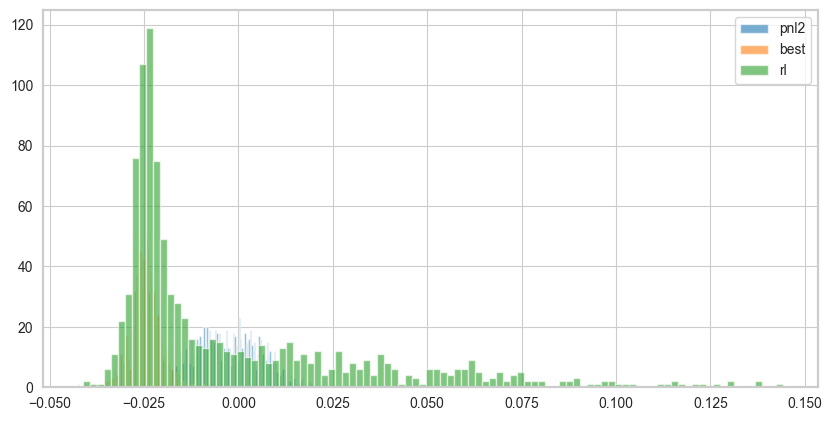

-0.002435079770266602
-0.002477997416248388


In [49]:
plt.hist(pnl2, bins=100, alpha=0.6, label='pnl2')
plt.hist(delta_best, bins=100, alpha=0.6, label='best')
plt.hist(delta_pnl, bins=100, alpha=0.6, label='rl')
plt.legend()
plt.show()

print(np.mean(delta_pnl))
print(np.mean(pnl2))

# 2. For Env

In [11]:
from Env.env import BSMarket
env = BSMarket(1000, cost=1e-3)

env 'BSMarket was created!


In [12]:
env.underlying_prices.shape

(30, 1000)

In [24]:
def delta_eval2():
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    # i = 0
    while not done:
        action = env.delta[env.now+1].copy()
        # moneyness, expiry, volatility = [obs[..., j] for j in range(3)]
        # action = european_call_delta(moneyness, expiry, volatility)
        # moneyness, expiry, volatility = [obs[..., j] for j in range(3)]
        # action = european_call_delta(moneyness, expiry, volatility)
        # assert np.all(abs(action - self.delta[i]) < 1e-5)
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']
        # i += 1

    return total_raw_reward

In [25]:
delta_pnl = delta_eval2()